## Initialisation time series

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
#from keras.backend.tensorflow_backend import set_session
import keras
import seaborn as sns
import pandas as pd
import sys, time
import numpy as np
import warnings


from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
#from math import sqrt


warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__))
print("tensorflow version {}".format(tf.__version__))

INFO:tensorflow:Using local port 23439
INFO:tensorflow:Using local port 16140
INFO:tensorflow:Using local port 17218
INFO:tensorflow:Using local port 20095
INFO:tensorflow:Using local port 20269
INFO:tensorflow:Using local port 20717
INFO:tensorflow:Using local port 18312
INFO:tensorflow:Using local port 15069
INFO:tensorflow:Using local port 15173
INFO:tensorflow:Using local port 15309
python 3.7.3 (default, Jul 25 2020, 13:03:44) 
[GCC 8.3.0]
keras version 2.4.3
tensorflow version 2.4.0-dev20201012


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  app.launch_new_instance()


In [2]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [0, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(0, 0.9))
	scaler = scaler.fit(train)
	print(scaler.data_min_)
	print(scaler.data_max_)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	print(X.shape)
	model = tf.keras.models.Sequential([
		#tf.keras.layers.Input(shape=(1,1), name='input'),
		tf.keras.layers.LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=False),
		#tf.keras.layers.Flatten(),
		tf.keras.layers.Dense(1,name='output')
	])
	model.compile(loss='mean_squared_error', optimizer='adam')
#	model.compile(optimizer='adam',
#                  loss='sparse_categorical_crossentropy',
#                  metrics=['accuracy'])
	model.summary()
	#for i in range(nb_epoch):
	#	model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
	#	model.reset_states()
	model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


## Evaluation

Fonction de détermination de l'erreur absolue en pourcentage

Combien de \% d'écart en moyenne entre la donnée prédite et la donnée mesurée

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
     return ((np.fabs(y_true - y_pred)/y_true).mean())

## Importation des données

Colonnes importées : 2e, 3e et 8e colonnes

2e colonne : Temps
3e colonne : identifiant Antenne
7e colonne : Quantité de données

In [4]:
dataframe = read_csv('Z1_RYG_20190423_cost.csv', usecols=[0,4], engine='python')

In [5]:
dataset = dataframe.values

## Sélection des données

Isolation d'une antenne (ID : 39)

Convertion du temps en heures

In [6]:
newdataset1 = []
newdataset2 = []
for i in range(len(dataset)):
    a = i
    b = dataset[i, 1]
    newdataset1.append(a)
    newdataset2.append(b)

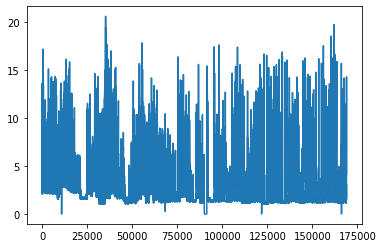

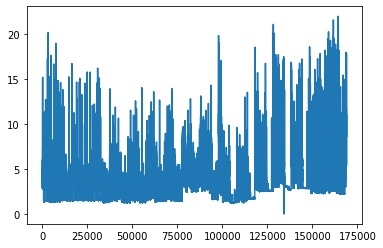

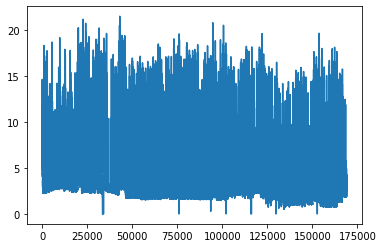

In [7]:
raw_values = np.asarray(newdataset2)
l=len(raw_values)
plt.plot(raw_values[:int(l/3)])
plt.show()
plt.plot(raw_values[int(l/3):-int(l/3)])
plt.show()
plt.plot(raw_values[-int(l/3):])
plt.show()

## Découpage du jeu de données

Définition d'un jeu d'entrainement et d'un jeu de test

Mise à l'échelle des données sur l'intervalle \[0,1\]

[-11.3272 -11.3272]
[11.03015 11.03015]


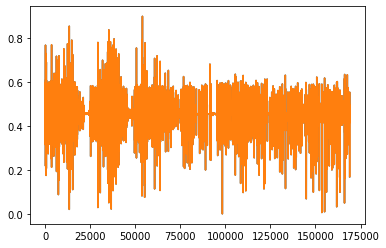

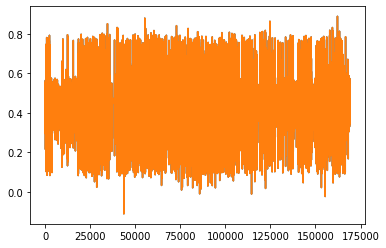

In [8]:
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-int(l/3)], supervised_values[-int(l/3):]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

plt.plot(train_scaled[:int(l/3)])
plt.show()
plt.plot(test_scaled[:int(l/3)])
plt.show()

## Entrainement

In [ ]:
lstm_model = fit_lstm(train_scaled, 1, 1, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

(337959, 1, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 1)                    12        
_________________________________________________________________
output (Dense)               (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


## Prédiction

Prédiction de la donnée et établissement d'un jeu de données prédite.

In [ ]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	expected = raw_values[len(train) + i + 1]

	predictions.append(yhat)

for i in range(len(test_scaled)):
	print('hour=%d, Predicted=%f, Expected=%f' % ((i+1)/6, predictions[i], raw_values[len(train) + i + 1]))

Generate proper data with 1 data shift

In [ ]:
# walk-forward validation on the test data
y_train = list()
X_train = list()
y_train.append(test_scaled[0, 0:-1][0])
X_train.append(0)
for i in range(1,len(test_scaled)):
	# make one-step forecast
    X_train.append(test_scaled[i-1, 0:-1][0])
    y_train.append(test_scaled[i, 0:-1][0])
    
for i in range(len(test_scaled)):
	print('X_train=%f, y_train=%f' % (X_train[i], y_train[i]))

## LSTM model

Our goal is to create a LSTM model to predict y_train using the time series X_train

In [ ]:
from keras import models 
from keras import layers

def define_model(len_ts,
                 hidden_neurons = 1,
                 nfeature=1,
                 batch_size=None,
                 stateful=False):
    in_out_neurons = 1
    
    inp = layers.Input(batch_shape= (batch_size, len_ts, nfeature),
                       name="input")  

    rnn = layers.LSTM(hidden_neurons, 
                    return_sequences=True,
                    stateful=stateful,
                    name="RNN")(inp)

    dens = layers.TimeDistributed(layers.Dense(in_out_neurons,name="dense"))(rnn)
    model = models.Model(inputs=[inp],outputs=[dens])
    
    model.compile(loss="mean_squared_error",
                  sample_weight_mode="temporal",
                  optimizer="adam")
    return(model,(inp,rnn,dens))

In [ ]:
X_train_array = np.array(X_train)
y_train_array = np.array(y_train)
hunits = 1
model1, _ = define_model(
    hidden_neurons = hunits,
    len_ts = X_train_array.shape[0])
model1.summary()

In [ ]:
w = np.zeros(y_train_array.shape[:2])
D=1
w[D:] = 1 
w_train = w

In [ ]:
from keras.callbacks import ModelCheckpoint
start = time.time()
hist1 = model1.fit(X_train_array, y_train_array, 
                   batch_size=2**9,
                   epochs=200, 
                   verbose=False,
                   sample_weight=w_train,
                   validation_split=0.05,
                   callbacks=[
                   ModelCheckpoint(filepath="weights{epoch:03d}.hdf5")])
end = time.time()
print("Time took {:3.1f} min".format((end-start)/60))

In [ ]:
labels = ["loss","val_loss"]
for lab in labels:
    plt.plot(hist1.history[lab],label=lab + " model1")
plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
for layer in model1.layers:
        if "LSTM" in str(layer):
            weightLSTM = layer.get_weights()
warr,uarr, barr = weightLSTM
print(warr)
print("\n")
print(uarr)
print("\n")
print(barr)

print(model1.layers[2].get_weights())
warr.shape,uarr.shape,barr.shape

In [ ]:
def sigmoid(x):
    return(1.0/(1.0+np.exp(-x)))
def LSTMlayer(weight,x_t,h_tm1,c_tm1):
    '''
    c_tm1 = np.array([0,0]).reshape(1,2)
    h_tm1 = np.array([0,0]).reshape(1,2)
    x_t   = np.array([1]).reshape(1,1)
    
    warr.shape = (nfeature,hunits*4)
    uarr.shape = (hunits,hunits*4)
    barr.shape = (hunits*4,)
    '''
    warr,uarr, barr = weight
    s_t = (x_t.dot(warr) + h_tm1.dot(uarr) + barr)
    hunit = uarr.shape[0]
    i  = sigmoid(s_t[:,:hunit])
    f  = sigmoid(s_t[:,1*hunit:2*hunit])
    _c = np.tanh(s_t[:,2*hunit:3*hunit])
    o  = sigmoid(s_t[:,3*hunit:])
    c_t = i*_c + f*c_tm1
    h_t = o*np.tanh(c_t)
    return(h_t,c_t)

In [ ]:
c_tm1 = np.array([0]*hunits).reshape(1,hunits)
h_tm1 = np.array([0]*hunits).reshape(1,hunits)

In [ ]:
xs  = train_scaled[:,0]
for i in range(len(xs)):
    x_t = xs[i].reshape(1,1)
    h_tm1,c_tm1 = LSTMlayer(weightLSTM,x_t,h_tm1,c_tm1)
print("h3={}".format(h_tm1))
print("c3={}".format(c_tm1))

In [ ]:
batch_size = 1
len_ts = len(xs)
nfeature = 1

inp = layers.Input(batch_shape= (batch_size, len_ts, nfeature),
                       name="input")  
rnn,s,c = layers.LSTM(hunits, 
                         return_sequences=True,
                         stateful=False,
                         return_state=True,
                         name="RNN")(inp)
states = models.Model(inputs=[inp],outputs=[s,c, rnn])

for layer in states.layers:
    for layer1 in model1.layers:
        if layer.name == layer1.name:
            layer.set_weights(layer1.get_weights())
            
h_t_keras, c_t_keras, rnn = states.predict(xs.reshape(1,len_ts,1))
print("h3={}".format(h_t_keras))
print("c3={}".format(c_t_keras))

In [ ]:
model1.layers[1].get_weights()[0]

In [ ]:
file_object =  open('parameters.h', 'w')

In [ ]:
file_object.write("//\n// Generated by spiderweak using Python.\n//\n\n#ifndef CPP_PARAMETERS_H\n#define CPP_PARAMETERS_H\n\n")

In [ ]:
file_object.write("#define HUNIT " + str(hunits) + "\n\n")

In [ ]:
file_object.write("#endif //CPP_PARAMETERS_H\n\nconst int hunit = HUNIT;\n\nconst float lstm_cell_input_weights[4 * HUNIT] = {")

In [ ]:
states.layers[1].get_weights()[0].tofile("weights.txt", sep=", ", format="%s")

In [ ]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [ ]:
file_object.write("};\n\nconst float lstm_cell_hidden_weights[4 * HUNIT * HUNIT] = {")

In [ ]:
states.layers[1].get_weights()[1].tofile("weights.txt", sep=", ", format="%s")

In [ ]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [ ]:
file_object.write("};\n\nconst float lstm_cell_bias[4 * HUNIT] = {")

In [ ]:
states.layers[1].get_weights()[2].tofile("weights.txt", sep=", ", format="%s")

In [ ]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [ ]:
file_object.write("};\n\nfloat lstm_cell_hidden_layer[HUNIT] = {")

In [ ]:
h_t_keras.tofile("weights.txt", sep=", ", format="%s")

In [ ]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [ ]:
file_object.write("};\nfloat lstm_cell_cell_states[HUNIT] = {")

In [ ]:
c_t_keras.tofile("weights.txt", sep=", ", format="%s")

In [ ]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [ ]:
file_object.write("};\n\nconst float dense_weights[HUNIT] = {")

In [ ]:
model1.layers[2].get_weights()[0].tofile("weights.txt", sep=", ", format="%s")

In [ ]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [ ]:
file_object.write("};\nconst float dense_bias = ")

In [ ]:
model1.layers[2].get_weights()[1].tofile("weights.txt", sep=", ", format="%s")

In [ ]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [ ]:
file_object.write(";\n")

In [ ]:
file_object.close()

In [ ]:


fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(1,2,1)
ax.plot(h_tm1.flatten(),h_t_keras.flatten(),"p")
ax.set_xlabel("h by hand")
ax.set_ylabel("h by Keras")

ax = fig.add_subplot(1,2,2)
ax.plot(c_tm1.flatten(),c_t_keras.flatten(),"p")
ax.set_xlabel("c by hand")
ax.set_ylabel("c by Keras")
plt.show()